This notebook reproduces figures in Lin & Daylan (2026), with the exception that codes Fig. 3, 10, 11 and the data analysis behind those figures are in a separate script, analyze_R_vs_Tirr.ipynb.

# Import packages, define constants, and import database

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'stix'
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator, LogLocator
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import norm
from collections import defaultdict
import string
import glob

In [2]:
# potentially useful constants in SI
c = 299792458.0 # speed of light in m / s
h = 6.62607015e-34 # Planck's constant in m2 kg / s
G = 6.67430e-11  # gravitational constant, https://physics.nist.gov/cgi-bin/cuu/Value?bg
Re = 6371000.0  # Earth radius
Me = 5.9722e24  # Earth mass, https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
Rjup = 69911 * 1.0e3
Mjup = 1898.13e24 
kb = 1.380649e-23 # Boltzmann constant, J/K
massH = 1.66053906660e-27 # mass of H atom in kg
sigma_SB = 5.670374419e-8 # Stefan–Boltzmann constant in W m-2 K-4
Msun = 1.989e+30
Rsun = 6.957e+8
AU = 1.496e+11
AU_cgs = 1.496e+11 * 100.0
seconds_in_day = 24 * 3600.0
solar_constant = 1361.0 # W/m2

# define solar luminosity in both SI and cgs
Lsun = 3.939e26 # W
Lsun_cgs = 3.939e33 # erg/s

In [3]:
# read in the database
# this database contains data for all 1289 planets analyzed in the paper
data_planets = pd.read_csv("Data_all_planets.csv", delimiter=",")
print(len(data_planets))

# this database contains data for rocky exoplanets with dayside emission temperature observations
data_observed = pd.read_csv("Data_observed_planets.csv")
print(len(data_observed))

1289
25


In [4]:
# define some helper functions that will be called later
def linear_func(B, x):
    return B[0] * x + B[1]


def fit_linear_odr_interval(x_fit, cov_beta):
    J = np.array([x_fit, np.ones_like(x_fit)]).T
    cov = cov_beta
    y_fit_err = np.sqrt(np.sum((J @ cov) * J, axis=1))
    return y_fit_err


def broken_power_law(beta, x):
    A, xb, a1, a2 = beta
    return np.where(x <= xb, A * (x / xb)**(-a1), A * (x / xb)**(-a2))

def F_tidal(M, R, e, a, Im_k2=-3.0e-3, G=6.67430e-11):
    """
    Compute tidal heating rate F_tidal.
    M: stellar mass (same units as used consistently)
    R: planet radius
    e: eccentricity
    a: semi-major axis
    Im_k2: imaginary part of k2 (or simply Im(k2) value)
    Returns scalar or numpy array.
    """
    C = -21.0 / (8.0 * np.pi) * Im_k2 * G**1.5
    return C * (M**(2.5)) * (R**3) * (e**2) * (a**(-7.5))  # note 15/2 = 7.5


def analytic_sigma_F_independent(M, R, e, a, sigma_M, sigma_R, sigma_e, sigma_a, Im_k2=-3.0e-3, G=6.67430e-11):
    """
    Analytic propagation assuming independent (uncorrelated) errors.
    Returns (F, sigma_F).
    """
    F = F_tidal(M, R, e, a)
    
    # guard against zero / extremely small denominators
    tiny = np.finfo(float).eps
    M_ = np.maximum(np.abs(M), tiny)
    R_ = np.maximum(np.abs(R), tiny)
    e_ = np.maximum(np.abs(e), tiny)
    a_ = np.maximum(np.abs(a), tiny)
    
    # relative contributions
    term_M = (2.5/2.0 * sigma_M / M_)  # note 5/2 divided by 1 -> (5/2)*(sigma_M/M)
    # Above line simplified to 2.5? Actually 5/2 = 2.5, so use 2.5.
    term_M = (2.5 * sigma_M / M_)
    term_R = (3.0 * sigma_R / R_)
    term_e = (2.0 * sigma_e / e_)
    term_a = (7.5 * sigma_a / a_)  # 15/2 = 7.5

    sigmaF_over_F = np.sqrt(term_M**2 + term_R**2 + term_e**2 + term_a**2)
    sigmaF = np.abs(F) * sigmaF_over_F
    return sigmaF


def delta_R_tidal(F_tidal, F_insol, sigma_Ft, sigma_Fi):
    """
    Compute Delta R_tidal and its uncertainty.

    Parameters
    ----------
    F_tidal : float
        Tidal heating flux [W/m^2]
    F_insol : float
        Insolation flux [W/m^2]
    sigma_Ft : float
        Uncertainty in F_tidal [W/m^2]
    sigma_Fi : float
        Uncertainty in F_insol [W/m^2]

    Returns
    -------
    R : float
        Delta R_tidal (dimensionless)
    sigma_R : float
        Uncertainty in Delta R_tidal
    """
    R = (1 + F_tidal / F_insol) ** 0.25

    # derivatives
    prefactor = 0.25 * (1 + F_tidal / F_insol) ** (-0.75)
    dRdFt = prefactor * (1 / F_insol)
    dRdFi = prefactor * (-F_tidal / F_insol**2)

    sigma_R = np.sqrt((dRdFt * sigma_Ft)**2 + (dRdFi * sigma_Fi)**2)

    return R, sigma_R

# Fig. 1. M-R Plots
Caption from the paper: Mass-radius plot for exoplanets studied in this work. Rocky (procky $\geq$ 32%) planets are shown in black, while non-rocky planets are shown in gray. Observed rocky exoplanets (Table 1) are highlighted in red. Constant composition curves calculated using L. Zeng et al. (2016) rock (MgSiO$_3$) and iron equations of state, as well as the AQUA water equation of state (J. Haldemann et al. 2020), are plotted for comparison.

In [5]:
# read in M-R curves calculated using the exoplanet interior simulation code, CORGI
corgi_indir = "MR_curves/"
corgi_mr_cmf00 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf000.txt", skip_header=1)
corgi_mr_cmf01 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf010.txt")
corgi_mr_cmf02 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf020.txt")
corgi_mr_cmf03 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf030.txt")
corgi_mr_cmf04 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf040.txt")
corgi_mr_cmf05 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf050.txt")
corgi_mr_cmf06 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf060.txt")
corgi_mr_cmf07 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf070.txt")
corgi_mr_cmf08 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf080.txt")
corgi_mr_cmf09 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf090.txt")
corgi_mr_cmf10 = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_cmf100.txt", skip_header=1)
corgi_mr_water = np.genfromtxt(corgi_indir + "MR_curve_water_AQUAEOS.txt", skip_header=1)
corgi_mr_50rock_50water = np.genfromtxt(corgi_indir + "MR_curve_rocky_Zeng2016EOS_50rock_50water.txt")

mr_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
             '#bcbd22', '#17becf']

In [6]:
observed_planets = ['55 Cnc e', 'GJ 1132 b', 'GJ 1252 b', 'GJ 367 b', 'GJ 486 b', 'K2-141 b', 
                    'LHS 1478 b', 'LHS 3844 b', 'LTT 1445 A b', 'TOI-1468 b', 'TOI-1685 b', 
                    'TOI-431 b', 'TRAPPIST-1 b', 'TRAPPIST-1 c', 'LHS 1140 c', 'LTT 3780 b', 
                    'GJ 3929 b', 'TOI-561 b']

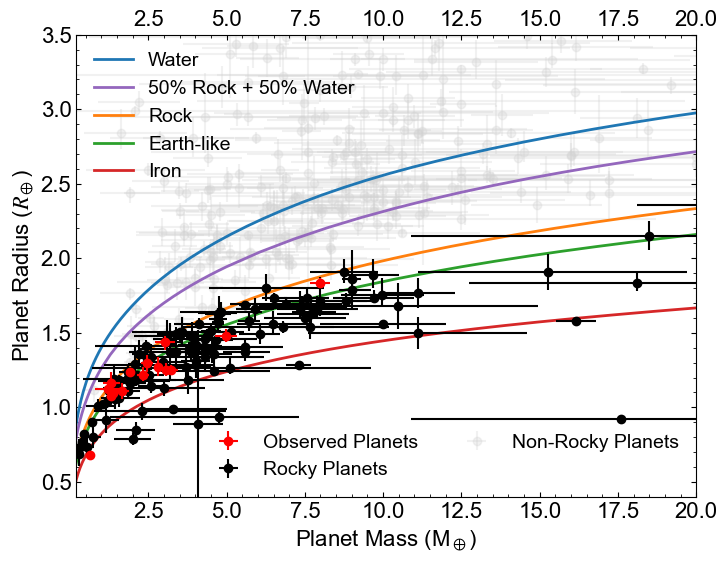

In [7]:
# plot CORGI M-R curves and the rho_HD curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# plot M-R curves with various compositions
# pure water
ax.plot(corgi_mr_water[:,1], corgi_mr_water[:,2], lw=2, label="Water", color=mr_colors[0])
# 50% rock, 50% water
ax.plot(corgi_mr_50rock_50water[:,1], corgi_mr_50rock_50water[:,2], lw=2, label="50% Rock + 50% Water", 
        color=mr_colors[4])
# pure rock
ax.plot(corgi_mr_cmf00[:,1], corgi_mr_cmf00[:,2], lw=2, label="Rock", color=mr_colors[1])
# Earth-like 30% CMF
ax.plot(corgi_mr_cmf03[:,1], corgi_mr_cmf03[:,2], lw=2, label="Earth-like", color=mr_colors[2])
# iron
ax.plot(corgi_mr_cmf10[:,1], corgi_mr_cmf10[:,2], lw=2, label="Iron", color=mr_colors[3])

# plot planets as scatter points
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        # highlight observed planets
        if data_planets["planet_name"][i] in observed_planets:
            colori = "r"
            alphai = 1.0
            zorderi = 3
        else:
            colori = "k"
            alphai = 1.0
            zorderi = 2
    else:
        colori = "#D3D3D3"
        alphai = 0.3
        zorderi = 1
    
    ax.errorbar(data_planets["planet_mass"][i]*Mjup/Me, data_planets["planet_radius"][i]*Rjup/Re,
                xerr=[[data_planets["planet_mass_lower"][i]*Mjup/Me], 
                      [data_planets["planet_mass_upper"][i]*Mjup/Me]],
                yerr=[[data_planets["planet_radius_lower"][i]*Rjup/Re], 
                      [data_planets["planet_radius_upper"][i]*Rjup/Re]],
                marker='o', color=colori, alpha=alphai, zorder=zorderi)

legend1 = plt.legend(loc="upper left", fontsize=14, fancybox=True, framealpha=0)
ax.add_artist(legend1)  # keep this legend when adding another

# 2nd legend for error bars
planets_obs = ax.errorbar([0], [0], [3], [3], marker='o', color="r", alpha=1.0, linestyle="",
                          label="Observed Planets")
planets_rocky = ax.errorbar([0], [0], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                            label="Rocky Planets")
planets_nonrocky = ax.errorbar([0], [0], [3], [3], marker='o', color="#D3D3D3", alpha=0.3, linestyle="",
                               label="Non-Rocky Planets")
legend2 = ax.legend(handles=[planets_obs, planets_rocky, planets_nonrocky], loc='lower right', 
                    fontsize=14, fancybox=True, framealpha=0, ncol=2)

ax.set_xlim([0.2, 20])
ax.set_ylim([0.4, 3.5])
ax.set_xlabel(r'Planet Mass (M$_\oplus$)', fontsize=16)
ax.set_ylabel(r'Planet Radius ($R_\oplus$)', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, direction='in', 
                   labeltop=True)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# toggle for saving figure
# plt.savefig("Planet_MR_rocky_nonRocky.pdf", bbox_inches="tight")
# plt.savefig("Planet_MR_rocky_nonRocky.png", bbox_inches="tight", dpi=300)

plt.show()
plt.close()

# Fig. 2. Roche limit temperature, $T_{\rm irr,Roche}$
Caption from the paper: (a) Irradiation temperature $T_{\rm irr}$ and (b) ratio of $T_{\rm irr}$ to the maximum irradiation limited by the Roche distance, $T_{\rm irr}/T_{\rm irr,Roche}$, as functions of stellar effective temperature. In (a), two different $T_{\rm irr,Roche}$ limits assuming Earth-like (red) and super-Earth (green) compositions are shown. Temperatures at which silicates begin to melt (850 K) and are fully molten (1473 K) are shown for comparison (F. K. Lutgens et al. 2015). In (b), Mercury is shown as a red triangle for reference, and exoplanets closest to Roche limits are annotated. Planets near the Roche limit are ideal targets for the search for thermal emission excesses.

In [8]:
# read in the T_{irr, Roche} boundaries calculated by fitting stellar M-R-Teff
t0_roche_boundaries = pd.read_csv("Tirr_Roche_boundaries.csv", delimiter=",")

In [9]:
# define functions for calculating T0,Roche and its errors
def roche_temp(Teff, Rs, a):
    return Teff * np.sqrt(Rs / a)


# define functions for calculating a_Roche and its errors
def roche_distance(Rp, Ms, Mp):
    """
    Compute Roche distance a = 2.44 * Rp * (Ms/Mp)^(1/3)
    Rp, Ms, Mp can be scalars or numpy arrays (same shapes).
    """
    return 2.44 * Rp * (Ms / Mp)**(1.0/3.0)


# calculate Mercury parameters for reference
t0_mercury = roche_temp(5778.0, Rsun, 0.38709893*AU)
roche_distance_sun = roche_distance(1.0*Re, Msun, 1.0*Me)/AU
t0_roche_mercury = roche_temp(5778.0, Rsun, roche_distance_sun*AU)

/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nan

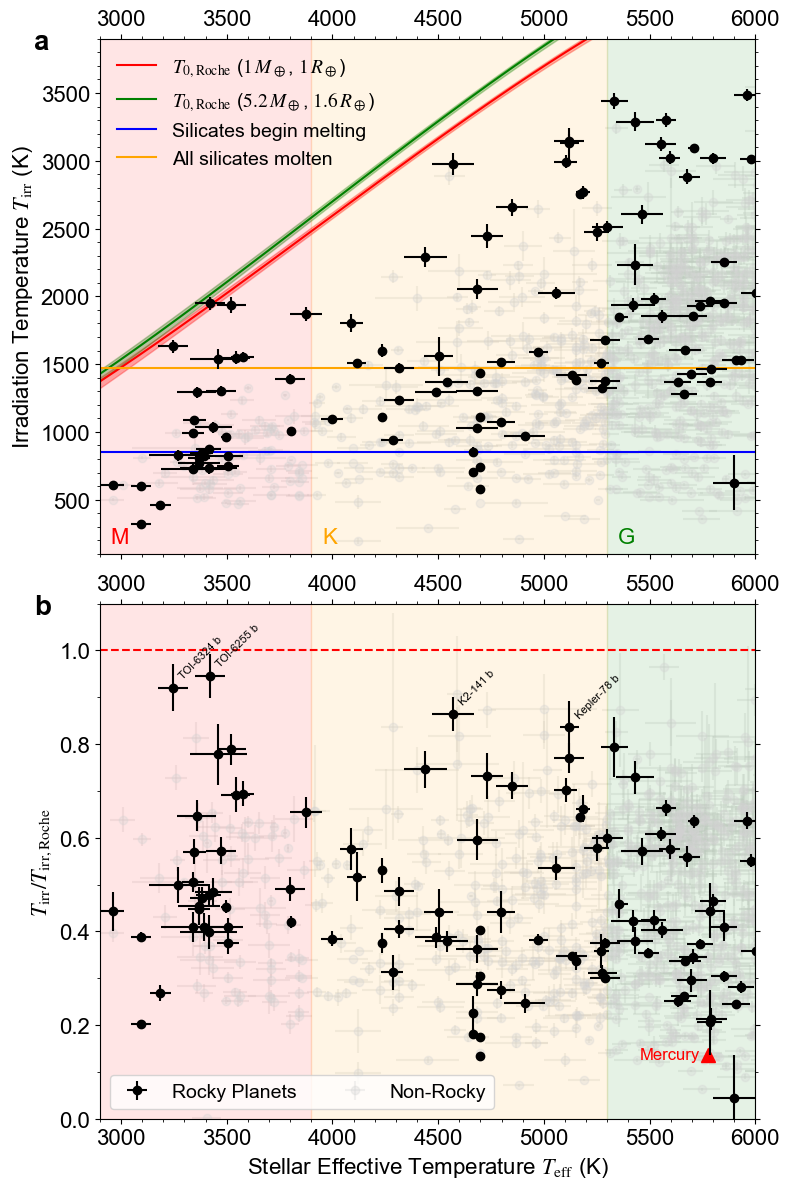

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

#============================================================
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        colori = "k"
        alphai = 1.0
        zorderi = 3
    else:
        colori = "#D3D3D3"
        alphai = 0.3
        zorderi = 1

    ax[0].errorbar(data_planets["stellar_eff_temp"][i], data_planets["T0_irr_temp"][i],
                    xerr=[[data_planets["stellar_eff_temp_lower"][i]], 
                          [data_planets["stellar_eff_temp_upper"][i]]],
                    yerr=data_planets["T0_irr_temp_err"][i],
                    marker='o', color=colori, alpha=alphai, zorder=zorderi)

# T_{irr, Roche} lines from file
ax[0].plot(t0_roche_boundaries["arr_teff_coolstar"], 
        t0_roche_boundaries["arr_t0roche_coolstar_Earth"], 
        color="r", label=r"$T_{0, \rm Roche}$ ($1\,M_\oplus$, $1\,R_\oplus$)")
ax[0].fill_between(t0_roche_boundaries["arr_teff_coolstar"], 
                t0_roche_boundaries["arr_t0roche_coolstar_Earth_lower"], 
                t0_roche_boundaries["arr_t0roche_coolstar_Earth_upper"], 
                color="r", alpha=0.3)

ax[0].plot(t0_roche_boundaries["arr_teff_coolstar"], 
        t0_roche_boundaries["arr_t0roche_coolstar_SuperEarth"], 
        color="g", label=r"$T_{0, \rm Roche}$ ($5.2\,M_\oplus$, $1.6\,R_\oplus$)")
ax[0].fill_between(t0_roche_boundaries["arr_teff_coolstar"], 
                t0_roche_boundaries["arr_t0roche_coolstar_SuperEarth_lower"], 
                t0_roche_boundaries["arr_t0roche_coolstar_SuperEarth_upper"], 
                color="g", alpha=0.3)

# show the regions for M, K, G stars
ax[0].fill_betweenx((100, 4000), 0, 3900, color="r", alpha=0.1)
ax[0].annotate("M", (2950, 180), fontsize=16, color="r")
ax[0].fill_betweenx((100, 4000), 3900, 5300, color="orange", alpha=0.1)
ax[0].annotate("K", (3950, 180), fontsize=16, color="orange")
ax[0].fill_betweenx((100, 4000), 5300, 6000, color="g", alpha=0.1)
ax[0].annotate("G", (5350, 180), fontsize=16, color="g")

# silicate melting line
ax[0].axhline(850.0, color="blue", label="Silicates begin melting")
ax[0].axhline(1473.0, color="orange", label="All silicates molten")

# ax[0].set_xlabel(r"Stellar effective temperature $T_{\rm eff}$", fontsize=16)
ax[0].set_ylabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[0].set_xlim([2900, 6000])
ax[0].set_ylim([100, 3900])
ax[0].yaxis.set_minor_locator(MultipleLocator(100))
ax[0].xaxis.set_minor_locator(MultipleLocator(100))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[0].legend(fontsize=14, loc="upper left", ncol=1, fancybox=True, framealpha=0)

#============================================================
# scatter points (PlanetS data)
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        colori = "k"
        alphai = 1.0
        zorderi = 3
    else:
        colori = "#D3D3D3"
        alphai = 0.3
        zorderi = 1
        
    t0_over_t0roche = data_planets["T0_irr_temp"][i]/data_planets["t0_roche_eachPlanet"][i]
    ax[1].errorbar(data_planets["stellar_eff_temp"][i], 
                t0_over_t0roche,
                xerr=[[data_planets["stellar_eff_temp_lower"][i]], [data_planets["stellar_eff_temp_upper"][i]]],
                yerr=data_planets["t0_over_t0roche_eachPlanet_err"][i],
                marker='o', color=colori, alpha=alphai, zorder=zorderi)
    if data_planets["p_rocky"][i] >= 0.32 and t0_over_t0roche >= 0.8: # this is +1 sigma value
        ax[1].annotate(data_planets["planet_name"][i], 
                    (data_planets["stellar_eff_temp"][i]+20, 
                     t0_over_t0roche+0.02),
                    fontsize=8, rotation=45)

# fake symbols for legend
ax[1].errorbar([], [], [], [], marker='o', color="k", capsize=5, alpha=1.0, linestyle="", 
            label="Rocky Planets")
ax[1].errorbar([], [], [], [], marker='o', color="#D3D3D3", capsize=5, alpha=0.3, linestyle="", 
            label="Non-Rocky")

ax[1].axhline(1.0, color="r", linestyle="--")

# plot Mercury for reference
ax[1].plot(5778.0, t0_mercury/t0_roche_mercury, 'r^', markersize=10)
ax[1].annotate("Mercury", (5778.0-40, t0_mercury/t0_roche_mercury), fontsize=12, color="r", 
               va="center", ha="right")

# show the regions for M, K, G stars
ax[1].fill_betweenx((0.0, 1.1), 0, 3900, color="r", alpha=0.1)
ax[1].fill_betweenx((0.0, 1.1), 3900, 5300, color="orange", alpha=0.1)
ax[1].fill_betweenx((0.0, 1.1), 5300, 6000, color="g", alpha=0.1)

ax[1].set_xlabel(r"Stellar Effective Temperature $T_{\rm eff}$ (K)", fontsize=16)
ax[1].set_ylabel(r"$T_{\rm irr}/T_{\rm irr, Roche}$", fontsize=16)
ax[1].set_ylim([0.0, 1.1])
ax[1].xaxis.set_minor_locator(MultipleLocator(100))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[1].legend(fontsize=14, loc="lower left", ncol=2, fancybox=True, framealpha=0.8)

plt.tight_layout()

# annotate a, b
ax[0].text(-0.1, 0.98, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(-0.1, 0.98, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')

# toggle for saving figure
# plt.savefig("StellarTeff_vs_Tirr_vs_TirrRoche.pdf", bbox_inches="tight")
# plt.savefig("StellarTeff_vs_Tirr_vs_TirrRoche.png", bbox_inches="tight", dpi=300)

plt.show()
plt.close()

Btw, it is normal to get some warnings about "All-NaN axis encountered" - not all exoplanet entries have the required data to calculate $T_{\rm irr}$ or the Roche distance, so those planets will produce NaN. But it's okay because they don't get plotted.

# Fig. 3. $\mathcal{R}$ as a function of $T_{\rm irr}$
Codes can be found in the other notebook, analyze_R_vs_Tirr.ipynb.

# Fig. 4. Residual heating (atmospheric loss & MO cooling)

In [11]:
cmapper_indir = "/Users/linzifan/Desktop/WashU_Research/CMAPPER/CMAPPER_rock/results_rocky_planets/"

seconds_in_yr = seconds_in_day * 365

# Find all planet evolution files
files = glob.glob(cmapper_indir + "*_evolution.txt")
cmapper_planets = []

flux_interp_dict = {}
time_r_interp_dict = {}

# Prepare storage
results = []

# Create a Series with planet_name as index for direct lookup
Tirr_lookup = data_planets.set_index("planet_name")["T0_irr_temp"]
Tirr_err_lookup = data_planets.set_index("planet_name")["T0_irr_temp_err"]
Finsol_lookup = data_planets.set_index("planet_name")["insolation_flux_combined"]
Finsol_err1_lookup = data_planets.set_index("planet_name")["insolation_flux_combined_upper"]
Finsol_err2_lookup = data_planets.set_index("planet_name")["insolation_flux_combined_lower"]

for f in files:
    planet_name = f.split("_evolution.txt")[0].split("/")[-1]
    cmapper_planets.append(planet_name)
    # Read file
    with open(f, "r") as infile:
        first_line = infile.readline().lstrip("#").strip()
        df = pd.read_csv(infile, delim_whitespace=True, names=first_line.split(","))
        df.columns = df.columns.str.strip()
    # Ensure correct columns
    if not {"time", "surface heat flux"}.issubset(df.columns):
        print(f"Skipping {planet_name}: missing required columns.")
        continue
    # Drop NaNs and sort
    df = df.dropna(subset=["time", "surface heat flux"]).sort_values("time")
    
    # Interpolation function (log-scale helps if time spans orders of magnitude)
    flux_interp_dict[planet_name] = interp1d(df["time"]/seconds_in_yr, # convert s to year
                                             df["surface heat flux"], kind="linear", 
                                             fill_value="extrapolate")
    
    # interpolate t as a function of R
    Finsol = Finsol_lookup[planet_name]
    Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
    R, _ = delta_R_tidal(df["surface heat flux"], Finsol, 0.0, Finsol_err)
    time_r_interp_dict[planet_name] = interp1d(R-1, df["time"]/seconds_in_yr, kind="linear")

/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nan

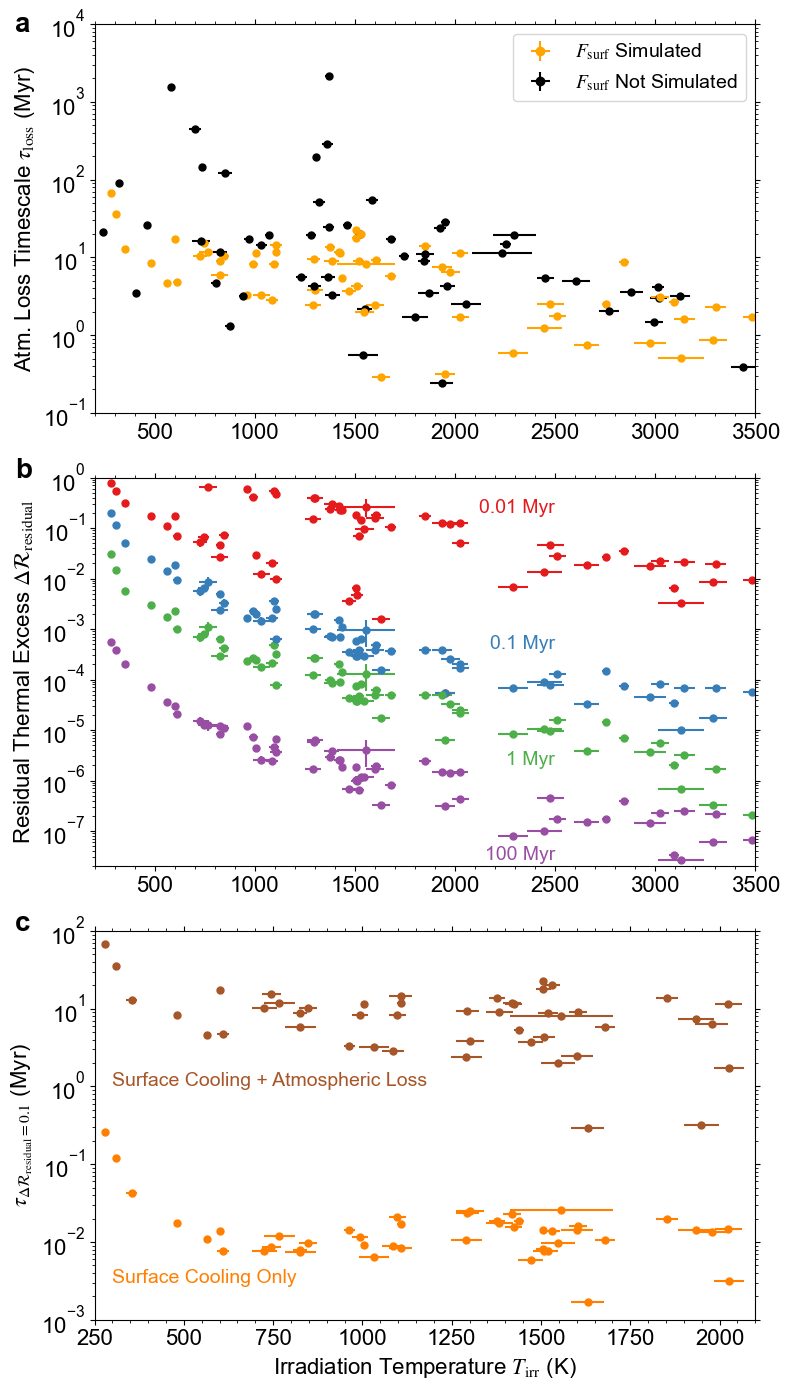

In [12]:
qual_colors = plt.colormaps["Set1"].colors

# plot the time it takes to decrease delta R to 0.1
fig, ax = plt.subplots(3, 1, figsize=(8, 14))

#======================================================================
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32: # plot rocky planets only
        if data_planets["planet_name"][i] in cmapper_planets:
            color="orange"
        else:
            color="k"
            
        ax[0].errorbar(data_planets["T0_irr_temp"][i], data_planets["atm_loss_tau"][i], 
                    xerr=data_planets["T0_irr_temp_err"][i],
                    color=color, marker="o", markersize=5)

planets_rocky = ax[0].errorbar([0], [0], [3], [3], marker='o', color="orange", alpha=1.0, linestyle="",
                            label=r"$F_{\rm surf}$ Simulated")
planets_nonrocky = ax[0].errorbar([0], [0], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                               label=r"$F_{\rm surf}$ Not Simulated")

ax[0].set_ylabel(r"Atm. Loss Timescale $\tau_{\rm loss}$ (Myr)", fontsize=16)
ax[0].set_xlim([200, 3500])
ax[0].set_ylim([1.0e-1, 1.0e4])
ax[0].set_yscale("log")
ax[0].xaxis.set_minor_locator(MultipleLocator(100))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)

ax[0].legend(fontsize=14, loc="upper right")

#======================================================================
# Create a Series with planet_name as index for direct lookup
Tirr_lookup = data_planets.set_index("planet_name")["T0_irr_temp"]
Tirr_err_lookup = data_planets.set_index("planet_name")["T0_irr_temp_err"]
Finsol_lookup = data_planets.set_index("planet_name")["insolation_flux_combined"]
Finsol_err1_lookup = data_planets.set_index("planet_name")["insolation_flux_combined_upper"]
Finsol_err2_lookup = data_planets.set_index("planet_name")["insolation_flux_combined_lower"]

for planet_name, func in flux_interp_dict.items():
    surface_flux = func(1e4)  # 0.01 Myr
    Finsol = Finsol_lookup[planet_name]
    Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
    R, sigma_R = delta_R_tidal(surface_flux, Finsol, 0.0, Finsol_err)
    ax[1].errorbar(Tirr_lookup[planet_name], R-1, 
                xerr=Tirr_err_lookup[planet_name],
                yerr=sigma_R,
                marker="o", markersize=5, color=qual_colors[0])
    
    surface_flux = func(1e5)  # 0.1 Myr
    Finsol = Finsol_lookup[planet_name]
    Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
    R, sigma_R = delta_R_tidal(surface_flux, Finsol, 0.0, Finsol_err)
    ax[1].errorbar(Tirr_lookup[planet_name], R-1, 
                xerr=Tirr_err_lookup[planet_name],
                yerr=sigma_R,
                marker="o", markersize=5, color=qual_colors[1])
    
    surface_flux = func(1e6)  # 1 Myr
    Finsol = Finsol_lookup[planet_name]
    Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
    R, sigma_R = delta_R_tidal(surface_flux, Finsol, 0.0, Finsol_err)
    ax[1].errorbar(Tirr_lookup[planet_name], R-1, 
                xerr=Tirr_err_lookup[planet_name],
                yerr=sigma_R,
                marker="o", markersize=5, color=qual_colors[2])
    
    surface_flux = func(1e8)  # 100 Myr
    Finsol = Finsol_lookup[planet_name]
    Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
    R, sigma_R = delta_R_tidal(surface_flux, Finsol, 0.0, Finsol_err)
    ax[1].errorbar(Tirr_lookup[planet_name], R-1, 
                xerr=Tirr_err_lookup[planet_name],
                yerr=sigma_R,
                marker="o", markersize=5, color=qual_colors[3])

# ax[1].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$", fontsize=16)
ax[1].set_ylabel(r"Residual Thermal Excess $\Delta\mathcal{R}_{\rm residual}$", fontsize=16)
ax[1].set_xlim([200, 3500])
ax[1].set_ylim([2.0e-8, 1.0])
ax[1].set_yscale("log")
ax[1].xaxis.set_minor_locator(MultipleLocator(100))
ax[1].yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax[1].yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)

ax[1].annotate("0.01 Myr", (2500, 2.0e-1), fontsize=14, color=qual_colors[0], ha="right")
ax[1].annotate("0.1 Myr", (2500, 4.0e-4), fontsize=14, color=qual_colors[1], ha="right")
ax[1].annotate("1 Myr", (2500, 2.0e-6), fontsize=14, color=qual_colors[2], ha="right")
ax[1].annotate("100 Myr", (2500, 2.7e-8), fontsize=14, color=qual_colors[3], ha="right")

#======================================================================
atm_loss_tau_lookup = data_planets.set_index("planet_name")["atm_loss_tau"]

for planet_name, func in time_r_interp_dict.items():
    try:
        ax[2].errorbar(Tirr_lookup[planet_name], func(0.1)/1.0e6, 
                    xerr=Tirr_err_lookup[planet_name],
                    color=qual_colors[4], marker="o", markersize=5)
        ax[2].errorbar(Tirr_lookup[planet_name], func(0.1)/1.0e6 + atm_loss_tau_lookup[planet_name], 
                    xerr=Tirr_err_lookup[planet_name],
                    color=qual_colors[6], marker="o", markersize=5)
    except ValueError:
        continue

ax[2].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[2].set_ylabel(r"$\tau_{\Delta\mathcal{R}_{\rm residual}=0.1}$ (Myr)", fontsize=16)
ax[2].set_xlim([250, 2100])
# ax[2].set_xlim([300, 3500])
ax[2].set_ylim([1.0e-3, 1.0e2])
# ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].xaxis.set_minor_locator(MultipleLocator(50))
ax[2].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)

ax[2].annotate("Surface Cooling Only", (300, 3.0e-3), fontsize=14, color=qual_colors[4])
ax[2].annotate("Surface Cooling + Atmospheric Loss", (300, 1.0e0), fontsize=14, color=qual_colors[6])

# annotate a, b, c
ax[0].text(-0.12, 0.98, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(-0.12, 1.0, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')
ax[2].text(-0.12, 1.0, string.ascii_lowercase[2], transform=ax[2].transAxes, 
           size=20, weight='bold')

plt.tight_layout()
# toggle for saving figure
# plt.savefig("R_residual_vs_Tirr.pdf", bbox_inches="tight")
# plt.savefig("R_residual_vs_Tirr.png", bbox_inches="tight", dpi=300)

plt.show()
plt.close()

# Fig. 5. Upper limit on tidal heat flux

In [13]:
# filter those data points with zero/NaN Ftidal_EarthLike or Ftidal_EarthLike_err
data_planets_Ftidal_EarthLike = data_planets[data_planets["Ftidal_EarthLike"] != 0]
data_planets_Ftidal_EarthLike = data_planets_Ftidal_EarthLike[data_planets_Ftidal_EarthLike["Ftidal_EarthLike"].notnull()]

print(len(data_planets_Ftidal_EarthLike))

821


In [14]:
# find the maximum eccentricity of rocky exoplanets for proper color coding
max_ecc = data_planets_Ftidal_EarthLike.loc[data_planets_Ftidal_EarthLike["p_rocky"] >= 0.32, "ecc"].max()
print(max_ecc)

0.36


In [15]:
norm_ecc = colors.Normalize(vmin=0.0, vmax=max_ecc, clip=True)
mapper_ecc = cm.ScalarMappable(norm=norm_ecc, cmap=cm.viridis)

/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


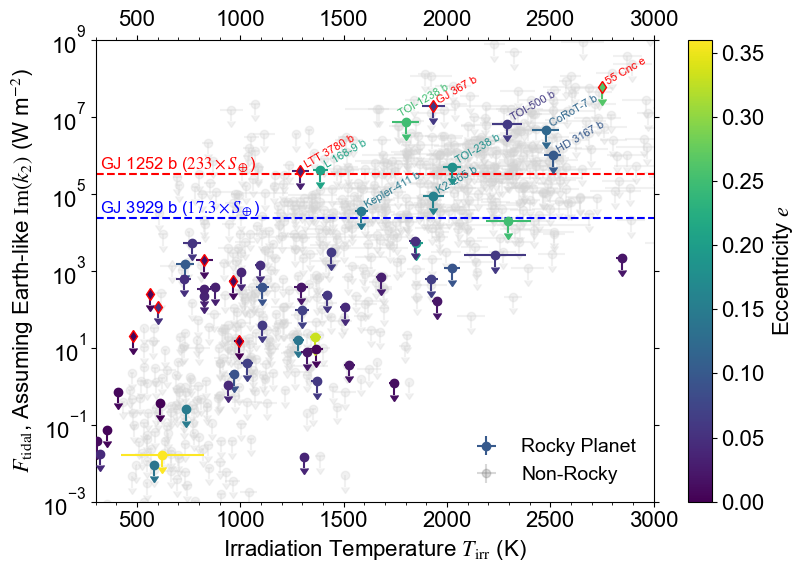

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for i in data_planets_Ftidal_EarthLike.index.to_list():
    if not pd.isna(data_planets_Ftidal_EarthLike["ecc"][i]):
        if data_planets_Ftidal_EarthLike["planet_name"][i] in observed_planets:
            marker = "d"; mec="r"
        else:
            marker = "o"; mec=mapper_ecc.to_rgba(data_planets_Ftidal_EarthLike["ecc"][i])
        
        if data_planets["p_rocky"][i] >= 0.32:
            no_ftidal_err = data_planets_Ftidal_EarthLike["Ftidal_EarthLike_err"][i] == 0 or \
                pd.isna(data_planets_Ftidal_EarthLike["Ftidal_EarthLike_err"][i])
            ftidal_upper_bound = data_planets_Ftidal_EarthLike["Ftidal_EarthLike"][i] if no_ftidal_err else \
                data_planets_Ftidal_EarthLike["Ftidal_EarthLike"][i] + data_planets_Ftidal_EarthLike["Ftidal_EarthLike_err"][i]
            ax.errorbar(data_planets_Ftidal_EarthLike["T0_irr_temp"][i], 
                        y = data_planets_Ftidal_EarthLike["Ftidal_EarthLike"][i] if no_ftidal_err else ftidal_upper_bound,
                        xerr=data_planets_Ftidal_EarthLike["T0_irr_temp_err"][i],
                        yerr=ftidal_upper_bound*0.5,
                        color=mapper_ecc.to_rgba(data_planets_Ftidal_EarthLike["ecc"][i]),
                        markeredgecolor=mec,
                        uplims=True,
                        marker=marker, zorder=3)
            # annotate planets with large Ftidal
            if ftidal_upper_bound >= 1361*17.3:
                if data_planets_Ftidal_EarthLike["planet_name"][i] != "TOI-1238 b":
                    ax.annotate(data_planets_Ftidal_EarthLike["planet_name"][i], 
                                (data_planets_Ftidal_EarthLike["T0_irr_temp"][i]+10, 
                                 ftidal_upper_bound*1.2),
                                fontsize=8, rotation=30, color=mec)
                else:
                    ax.annotate(data_planets_Ftidal_EarthLike["planet_name"][i], 
                                (data_planets_Ftidal_EarthLike["T0_irr_temp"][i]-45, 
                                 ftidal_upper_bound*1.4),
                                fontsize=8, rotation=30, color=mec)
        else:
            ax.errorbar(data_planets_Ftidal_EarthLike["T0_irr_temp"][i], 
                        data_planets_Ftidal_EarthLike["Ftidal_EarthLike"][i],
                        xerr=data_planets_Ftidal_EarthLike["T0_irr_temp_err"][i],
                        yerr=data_planets_Ftidal_EarthLike["Ftidal_EarthLike"][i]*0.5,
                        color="#D3D3D3",
                        marker=marker, uplims=True, alpha=0.3, zorder=1)

# fake symbols for legend
ax.errorbar([1], [1], [1], [1], marker='o', color=mapper_ecc.to_rgba(0.1), alpha=1.0, linestyle="",
            label=r"Rocky Planet")
ax.errorbar([1], [1], [1], [1], marker='o', color="#808080", alpha=0.3, linestyle="", 
            label=r"Non-Rocky")

# plot Earth's insolation
ax.axhline(1361*233, color="r", linestyle="--")
ax.annotate(r"GJ 1252 b ($233\times S_\oplus$)", (320, 1361*233*1.3), fontsize=12, color="r")

ax.axhline(1361*17.3, color="b", linestyle="--")
ax.annotate(r"GJ 3929 b ($17.3\times S_\oplus$)", (320, 1361*17.3*1.3), fontsize=12, color="b")

# add colorbar to figure
cbar = fig.colorbar(mapper_ecc, ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel(r'Eccentricity $e$', fontsize=16)

ax.set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$F_{\rm tidal}$, Assuming Earth-like ${\rm Im}(k_2)$ (W m$^{-2}$)", fontsize=16)
ax.set_xlim([300, 3000])
ax.set_ylim([1.0e-3, 1.0e9])
ax.set_yscale("log")
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=14, loc="lower right", fancybox=True, framealpha=0)

# toggle for saving figure
# plt.savefig("Tirr_vs_Ftidal_Earthlike_Imk2.pdf", bbox_inches="tight")
# plt.savefig("Tirr_vs_Ftidal_Earthlike_Imk2.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

Here, I adjusted the eccentricity upper bound a bit to `max_ecc` instead of 0.4, which should make it a little bit easier to read eccentricity values from the colors.

# Fig. 6. $\Delta\mathcal{R}_{\rm tidal}$ as a function of $T_{\rm irr}$

In [17]:
# calculate the R and R error of GJ 367 b, assuming lower e (Zhang et al., 2024): 0.0027 ± 0.0008
# this is necessary because the number reported in NASA Exoplanet Archive (0.06) is much higher and leads
# to strong tidal heating; the figure will present tidal heating rates calculated from both eccentricities
for i in data_planets.index.to_list():
    if data_planets["planet_name"][i] == "GJ 367 b":        
        Ftidal_GJ367_lowe = F_tidal(data_planets["stellar_mass"][i]*Msun,
                                    data_planets["planet_radius"][i]*Rjup,
                                    0.0027,
                                    data_planets["semi_major_axis"][i]*AU)
        
        Ftidal_err_GJ367_lowe = \
            analytic_sigma_F_independent(data_planets["stellar_mass"][i]*Msun,
                                         data_planets["planet_radius"][i]*Rjup,
                                         0.0027,
                                         data_planets["semi_major_axis"][i]*AU,
                                         (data_planets["stellar_mass_upper"][i]+data_planets["stellar_mass_lower"][i])/2.0*Msun,
                                         (data_planets["planet_radius_upper"][i]+data_planets["planet_radius_lower"][i])/2.0*Rjup,
                                         0.0008,
                                         (data_planets["semi_major_axis_upper"][i]+data_planets["semi_major_axis_lower"][i])/2.0*AU)
        
        R_GJ367_lowe, sigma_R_GJ367_lowe = \
            delta_R_tidal(Ftidal_GJ367_lowe,
                          data_planets["insolation_flux_combined"][i],
                          Ftidal_err_GJ367_lowe,
                          (data_planets["insolation_flux_combined_upper"][i]+data_planets["insolation_flux_combined_lower"][i])/2.0)

/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/linzifan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


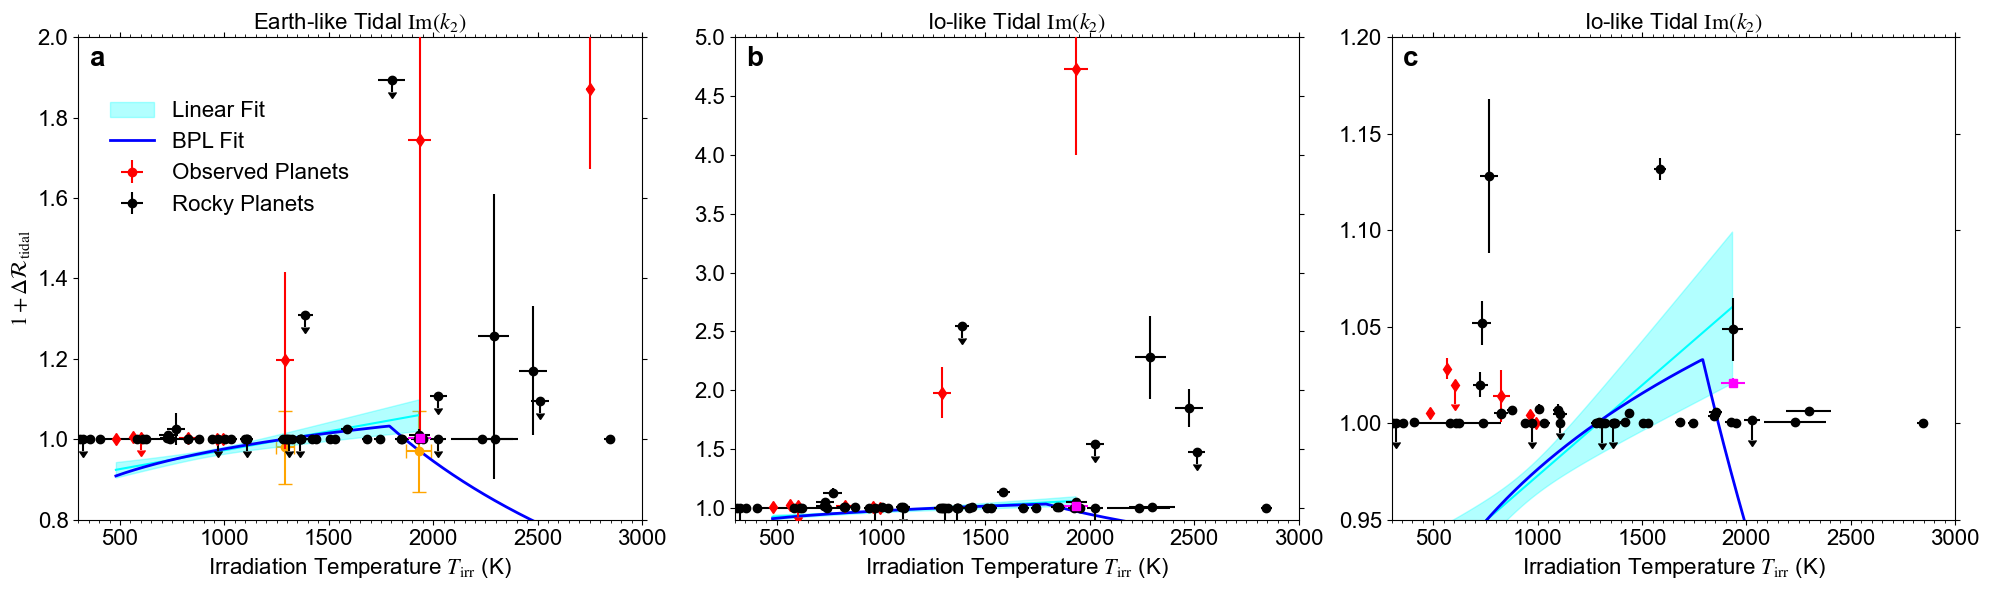

In [18]:
# plot R_tidal vs T0
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

#===============================================================
# plot the error bars of F_insol vs T_irr
for i in data_planets.index.to_list():
    if data_planets["delta_r_tidal"][i] != 1.0:
        if data_planets["planet_name"][i] in observed_planets:
            marker = "d"; color="r"
        else:
            marker = "o"; color="k"
        no_ftidal_err = data_planets["Ftidal_EarthLike_err"][i] == 0 or pd.isna(data_planets["Ftidal_EarthLike_err"][i])
        if data_planets["p_rocky"][i] >= 0.32:
            ax[0].errorbar(data_planets["T0_irr_temp"][i], data_planets["delta_r_tidal"][i],
                           xerr=data_planets["T0_irr_temp_err"][i],
                           yerr=data_planets["delta_r_tidal_err"][i] if not no_ftidal_err else 0.03, 
                           marker=marker, color=color, zorder=3, uplims=no_ftidal_err)

# plot measurements for some planets
for i in data_observed.index.to_list():
    if data_observed["pl_name"][i] in ["LTT 3780 b", "GJ 367 b"]:
        ax[0].errorbar(data_observed["T0_calculated"][i], data_observed["R_factor"][i], 
                       xerr=data_observed["T0_calculated_err"][i],
                       yerr=[[-data_observed["R_factor_err2"][i]], [data_observed["R_factor_err1"][i]]],
                       linestyle='', marker="o", capsize=5, color="orange")

# special case: GJ 367 b, new low ecc
ax[0].errorbar(1934.5963087495727, R_GJ367_lowe,
               xerr=57.249731283468265,
               yerr=sigma_R_GJ367_lowe, 
               marker="s", color="magenta", zorder=3)

# print fit results
# linear
slope, intercept, slope_err, intercept_err, p_value = 9.372068736583426e-05, 0.8791114082892632, 3.774844361760021e-05, 0.03606356895019623, 0.02450853720937718
x_fit = np.linspace(480.13, 1930.89, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, [[ 1.46414523e-09, -1.36161895e-06], [-1.36161895e-06, 1.33635999e-03]])       

ax[0].plot(x_fit, y_fit, color='cyan', zorder=2)
ax[0].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, label=r'Linear Fit',
                zorder=2)

# BPL
bpl_res = {'A': 1.033098016577723, 
           'xb': 1790.2379048649589, 
           'alpha1': -0.09734198280055256, 
           'alpha2': 0.7961145258430691, 
           'A_err': 0.031576031866121804, 
           'xb_err': 255.50378965124807, 
           'alpha1_err': 0.04276339785468326, 
           'alpha2_err': 0.21949608429103043, 
           'cov': np.array([[ 9.97045788e-04,  1.70540149e+00, -1.14308776e-03, 2.99124760e-03],
                         [ 1.70540149e+00,  6.52821865e+04,  2.48813047e+00, 5.32502145e+01],
                         [-1.14308776e-03,  2.48813047e+00,  1.82870820e-03, -4.39039166e-10],
                         [ 2.99124760e-03,  5.32502145e+01, -4.39039166e-10, 4.81785310e-02]]), 
           'res_var': 1.381716645690396, 
           'beta': np.array([ 1.03309802e+00,  1.79023790e+03, -9.73419828e-02,  7.96114526e-01]), 
           'y_model': np.array([0.71774087, 0.95820573, 1.01816471, 0.97292927, 0.97462464,
                             0.68939459, 0.98879954, 0.92992769, 0.97293922, 1.01822063,
                             1.01822063, 0.75372602, 0.92297695, 0.92297695, 0.90896997,
                             0.92836126, 1.00076234, 0.95775324, 0.95775324, 0.92297695,
                             0.90896997, 0.63888962, 0.63888962, 0.63888962])}
x_fit_bpl = np.linspace(480.13, 3274.5, 500)
y_fit_bpl = broken_power_law(bpl_res["beta"], x_fit_bpl)

ax[0].plot(x_fit_bpl, y_fit_bpl, 'b-', lw=2, label=r'BPL Fit', zorder=2)

# set labels, etc.
ax[0].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[0].set_ylabel(r"$1 + \Delta\mathcal{R}_{\rm tidal}$", fontsize=16)
ax[0].set_xlim([300, 3000])
ax[0].set_ylim([0.8, 2.0])
ax[0].xaxis.set_minor_locator(MultipleLocator(50))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)
ax[0].set_title(r"Earth-like Tidal ${\rm Im}(k_2)$", fontsize=16)

#===============================================================
# plot the error bars of F_insol vs T_irr
for i in data_planets.index.to_list():
    if data_planets["delta_r_tidal"][i] != 1.0:
        rtidal_io = (data_planets["delta_r_tidal"][i] - 1)*5 + 1
        if data_planets["planet_name"][i] in observed_planets:
            marker = "d"; color="r"
        else:
            marker = "o"; color="k"
        no_ftidal_err = data_planets["Ftidal_EarthLike_err"][i] == 0 or pd.isna(data_planets["Ftidal_EarthLike_err"][i])
        if data_planets["p_rocky"][i] >= 0.32:
            ax[1].errorbar(data_planets["T0_irr_temp"][i], rtidal_io,
                           xerr=data_planets["T0_irr_temp_err"][i],
                           yerr=data_planets["delta_r_tidal_err"][i] if not no_ftidal_err else 0.1, 
                           marker=marker, color=color, zorder=3, uplims=no_ftidal_err)

# special case: GJ 367 b, new low ecc
ax[1].errorbar(1934.5963087495727, (R_GJ367_lowe-1)*5+1,
               xerr=57.249731283468265,
               yerr=sigma_R_GJ367_lowe, 
               marker="s", color="magenta", zorder=3)

# print fit results
# linear
ax[1].plot(x_fit, y_fit, color='cyan', zorder=2)
ax[1].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, label=r'Linear Fit',
                zorder=2)
# BPL
ax[1].plot(x_fit_bpl, y_fit_bpl, 'b-', lw=2, label=r'BPL Fit', zorder=2)

# set labels, etc.
ax[1].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[1].set_xlim([300, 3000])
ax[1].set_ylim([0.9, 5.0])
ax[1].xaxis.set_minor_locator(MultipleLocator(50))
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)
ax[1].set_title(r"Io-like Tidal ${\rm Im}(k_2)$", fontsize=16)

#===============================================================
# plot the error bars of F_insol vs T_irr
for i in data_planets.index.to_list():
    if data_planets["delta_r_tidal"][i] != 1.0:
        rtidal_io = (data_planets["delta_r_tidal"][i] - 1)*5 + 1
        if data_planets["planet_name"][i] in observed_planets:
            marker = "d"; color="r"
        else:
            marker = "o"; color="k"
        no_ftidal_err = data_planets["Ftidal_EarthLike_err"][i] == 0 or pd.isna(data_planets["Ftidal_EarthLike_err"][i])
        if data_planets["p_rocky"][i] >= 0.32:
            ax[2].errorbar(data_planets["T0_irr_temp"][i], rtidal_io,
                        xerr=data_planets["T0_irr_temp_err"][i],
                        yerr=data_planets["delta_r_tidal_err"][i] if not no_ftidal_err else 0.01, 
                        marker=marker, color=color, zorder=3, uplims=no_ftidal_err)

# special case: GJ 367 b, new low ecc
ax[2].errorbar(1934.5963087495727, (R_GJ367_lowe-1)*5+1,
               xerr=57.249731283468265,
               yerr=sigma_R_GJ367_lowe, 
               marker="s", color="magenta", zorder=3)

# print fit results
# linear
ax[2].plot(x_fit, y_fit, color='cyan', zorder=2)
ax[2].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, label=r'Linear Fit',
                zorder=2)
# BPL
ax[2].plot(x_fit_bpl, y_fit_bpl, 'b-', lw=2, label=r'BPL Fit', zorder=2)

# set labels, etc.
ax[2].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[2].set_xlim([300, 3000])
ax[2].set_ylim([0.95, 1.2])
ax[2].xaxis.set_minor_locator(MultipleLocator(50))
ax[2].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)
ax[2].set_title(r"Io-like Tidal ${\rm Im}(k_2)$", fontsize=16)

#===============================================================
# annotate a, b, c
ax[0].text(0.02, 0.94, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(0.02, 0.94, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')
ax[2].text(0.02, 0.94, string.ascii_lowercase[2], transform=ax[2].transAxes, 
           size=20, weight='bold')

# fake labels for legend
planets_obs = ax[0].errorbar([0], [0], [3], [3], marker='o', color="r", alpha=1.0, linestyle="",
                             label="Observed Planets")
planets_rocky = ax[0].errorbar([0], [0], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                               label="Rocky Planets")
ax[0].legend(loc="center left", fontsize=16, fancybox=True, framealpha=0,
             bbox_to_anchor=(0.02, 0.75))

plt.tight_layout()

# toggle for saving figure
# plt.savefig("R_tidal_vs_Tirr_3tidalQ_NA.pdf", bbox_inches="tight")
# plt.savefig("R_tidal_vs_Tirr_3tidalQ_NA.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

You may notice that some labels are missing. That's because they were added later using editing software - adjusting label locations in Python was too tideous.

# Fig. 7. Tidal circularization timescale
Caption from the paper: Tidal circularization timescale $\tau_{\rm circ}$ as a function of tidal heat flux $F_{\rm tidal}$. Both Earth-like and Io-like Im$k_2$ and $\mathcal{Q}$ results are shown. Planets with large tidal $\Delta\mathcal{R}$ (Figure 6) are also vulnerable to rapid orbital circularization with $\tau_{\rm circ}$ as short as $\lesssim0.1$ Myr. Detecting large $\Delta\mathcal{R}_{\rm tidal}$ is therefore unlikely, unless high $e$ can be maintained.

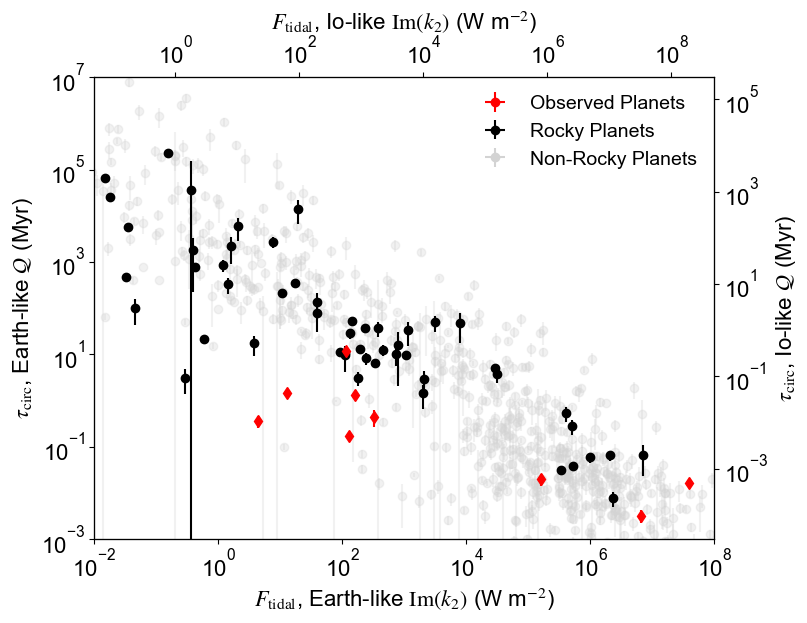

In [19]:
# plot R_tidal vs T0
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# plot the error bars of F_insol vs T_irr
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        if data_planets["planet_name"][i] in observed_planets:
            marker = "d"; color="r"; zorder=3
        else:
            marker = "o"; color="k"; zorder=2
        ax.errorbar(data_planets["Ftidal_EarthLike"][i], data_planets["tidal_circ_timescale"][i]/1.0e6,
                    yerr=data_planets["tidal_circ_timescale_err"][i]/1.0e6,
                    marker=marker, color=color, zorder=zorder)
    else:
        ax.errorbar(data_planets["Ftidal_EarthLike"][i], data_planets["tidal_circ_timescale"][i]/1.0e6,
                    yerr=data_planets["tidal_circ_timescale_err"][i]/1.0e6,
                    marker='o', color="#D3D3D3", alpha=0.3, zorder=1)

planets_obs = ax.errorbar([0], [0], [3], [3], marker='o', color="r", alpha=1.0, linestyle="",
                          label="Observed Planets")
planets_rocky = ax.errorbar([0], [0], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                            label="Rocky Planets")
planets_nonrocky = ax.errorbar([0], [0], [3], [3], marker='o', color="#D3D3D3", alpha=1.0, linestyle="",
                               label="Non-Rocky Planets")

ax.set_xlabel(r"$F_{\rm tidal}$, Earth-like ${\rm Im}(k_2)$ (W m$^{-2}$)", fontsize=16)
ax.set_ylabel(r"$\tau_{\rm circ}$, Earth-like $\mathcal{Q}$ (Myr)", fontsize=16)
ax.set_xlim([1.0e-2, 1.0e8])
ax.set_ylim([1.0e-3, 1.0e7])
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)

# second Y axis for Io-like tidal parameter
ax2 = ax.twinx()
ax2.set_ylim([1.0e-3/(100/3.0), 1.0e7/(100/3.0)])
ax2.set_ylabel(r"$\tau_{\rm circ}$, Io-like $\mathcal{Q}$ (Myr)", fontsize=16)
ax2.set_yscale("log")
ax2.tick_params(labelsize=16)

# second X axis for Io-like tidal parameter
ax3 = ax.twiny()
ax3.set_xlim([1.0e-2*5, 1.0e8*5])
ax3.set_xlabel(r"$F_{\rm tidal}$, Io-like ${\rm Im}(k_2)$ (W m$^{-2}$)", fontsize=16)
ax3.set_xscale("log")
ax3.tick_params(labelsize=16)

ax.legend(fontsize=14, loc="upper right", fancybox=True, framealpha=0)

# toggle for saving figure
# plt.savefig("Tau_circ_vs_Ftidal_NA.pdf", bbox_inches="tight")
# plt.savefig("Tau_circ_vs_Ftidal_NA.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

Again, labels do not appear because they were added during post-editing.

# Fig. 8. Induction heating
Caption from the paper: (a) Induction heat flux Finduction as a function of $T_{\rm irr}$. (b) Thermal emission excess produced by induction heat flux $\Delta\mathcal{R}_{\rm induction}$ as a function of $T_{\rm irr}$. Rocky exoplanets are shown in black, observed rocky exoplanets are highlighted in red, while all other planets are shown in gray. Even though some planets may have high induction heating on the order of $\sim10^3$ W m$^{−2}$ ,the relative contribution to dayside emission is too small ($\Delta\mathcal{R} < 10^{−3}$ for all planets). Induction heating, therefore, cannot explain the observed thermal excess.

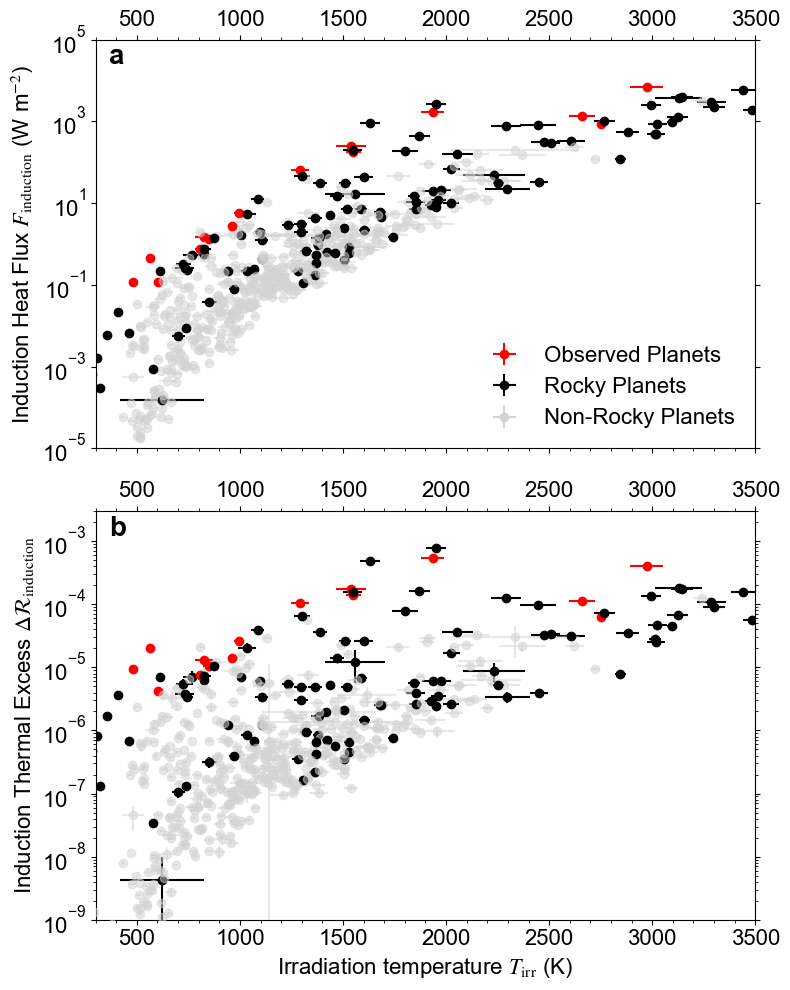

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

#============================================================
# scatter points (PlanetS data)
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        if data_planets["planet_name"][i] in observed_planets:
            colori = "r"
            alphai = 1.0
            zorderi = 3
        else:
            colori = "k"
            alphai = 1.0
            zorderi = 2
    else:
        colori = "#D3D3D3"
        alphai = 0.5
        zorderi = 1
        
    ax[0].errorbar(data_planets["T0_irr_temp"][i], data_planets["induction_heating_flux"][i],
                   xerr=data_planets["T0_irr_temp_err"][i],
                   marker='o', color=colori, alpha=alphai, zorder=3)

ax[0].set_ylabel(r"Induction Heat Flux $F_{\rm induction}$ (W m$^{-2}$)", fontsize=16)
ax[0].set_xlim([300, 3500])
ax[0].set_ylim([1.0e-5, 1.0e5])
ax[0].set_yscale("log")
ax[0].xaxis.set_minor_locator(MultipleLocator(100))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

#============================================================
# scatter points (PlanetS data)
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        if data_planets["planet_name"][i] in observed_planets:
            colori = "r"
            alphai = 1.0
            zorderi = 3
        else:
            colori = "k"
            alphai = 1.0
            zorderi = 2
    else:
        colori = "#D3D3D3"
        alphai = 0.5
        zorderi = 1
        
    ax[1].errorbar(data_planets["T0_irr_temp"][i], data_planets["delta_r_induction"][i]-1,
                   xerr=data_planets["T0_irr_temp_err"][i],
                   yerr=data_planets["delta_r_induction_err"][i],
                   marker='o', color=colori, alpha=alphai, zorder=3)

ax[1].set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[1].set_ylabel(r"Induction Thermal Excess $\Delta\mathcal{R}_{\rm induction}$", fontsize=16)
ax[1].set_ylim([1.0e-9, 3.0e-3])
ax[1].xaxis.set_minor_locator(MultipleLocator(100))
ax[1].set_yscale("log")
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

planets_obs = ax[0].errorbar([], [], [3], [3], marker='o', color="r", alpha=1.0, linestyle="",
                          label="Observed Planets")
planets_rocky = ax[0].errorbar([], [], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                            label="Rocky Planets")
planets_rocky = ax[0].errorbar([], [], [3], [3], marker='o', color="#D3D3D3", alpha=1.0, linestyle="",
                            label="Non-Rocky Planets")
ax[0].legend(fontsize=16, loc="lower right", ncol=1, fancybox=True, framealpha=0)

plt.tight_layout()

# annotate a, b
ax[0].text(0.02, 0.94, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(0.02, 0.94, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')

# toggle for saving figure
# plt.savefig("Finduction_vs_Tirr.pdf", bbox_inches="tight")
# plt.savefig("Finduction_vs_Tirr.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

# Fig. 9. Combined results: residual + tidal + induction heating
Caption from the paper: Combined thermal emission excess $\Delta\mathcal{R}_{\rm total} = \Delta\mathcal{R}_{\rm residual}+\Delta\mathcal{R}_{\rm tidal}+\Delta\mathcal{R}_{\rm indcution}$ as a function of $T_{\rm irr}$. Observed rocky exoplanets are highlighted in red, while all other rocky exoplanets are shown in black. The error bars sum the uncertainties in $\Delta\mathcal{R}_i$. Arrows indicate upper limits when uncertainties are unavailable. Observed exoplanets and planets with $\Delta\mathcal{R}_{\rm total} > 0.01$ are annotated, where the latter are interesting targets for future characterizations.

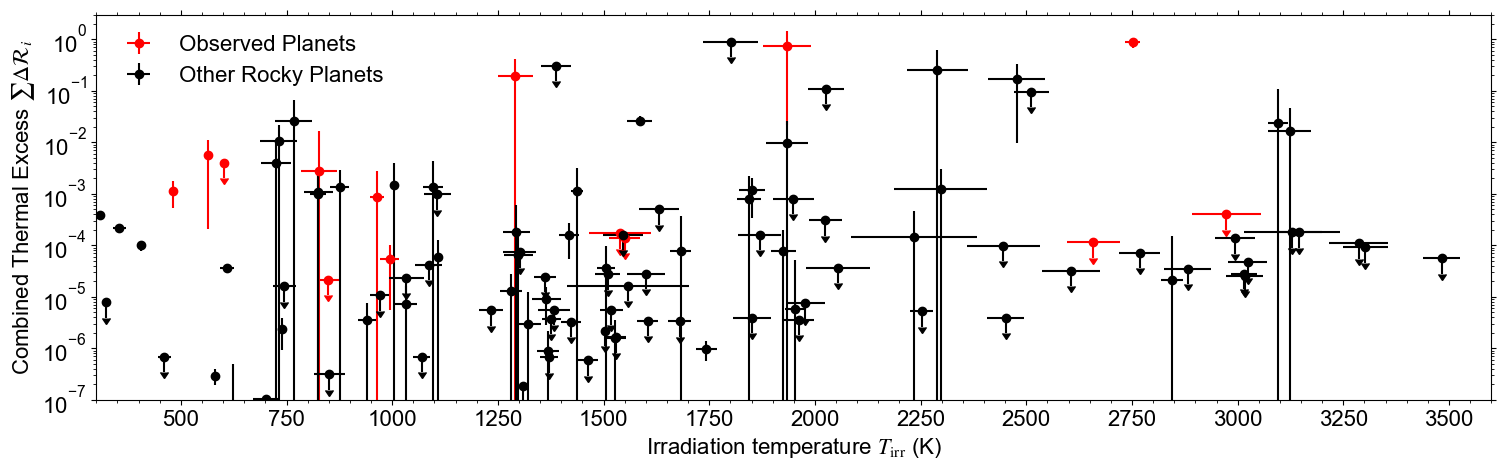

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

# scatter points (PlanetS data)
for i in data_planets.index.to_list():
    if data_planets["p_rocky"][i] >= 0.32:
        planet_name = data_planets["planet_name"][i]
        if planet_name in cmapper_planets:
            func = flux_interp_dict[planet_name]
            surface_flux = func(1.0e8)  # 100 Myr
            Finsol = Finsol_lookup[planet_name]
            Finsol_err = (Finsol_err1_lookup[planet_name] + Finsol_err2_lookup[planet_name])/2.0
            residual_heating_R, residual_heating_R_err = delta_R_tidal(surface_flux, Finsol, 0.0, Finsol_err)
            residual_heating_R = residual_heating_R - 1
        else:
            residual_heating_R = 0.0
            residual_heating_R_err = 0.0
        
        if data_planets["planet_name"][i] in observed_planets:
            colori = "r"
            alphai = 1.0
            zorderi = 3
        else:
            colori = "k"
            alphai = 1.0
            zorderi = 2
    
        # calculate R from three mechanisms (residual heating is calculated above)
        tidal_heating_R = data_planets["delta_r_tidal"][i] - 1
        induction_heating_R = data_planets["delta_r_induction"][i] - 1
        
        tidal_heating_R_err = data_planets["delta_r_tidal_err"][i]
        induction_heating_R_err = data_planets["delta_r_induction_err"][i]
        
        R_combined = residual_heating_R+tidal_heating_R+induction_heating_R
        R_err_combined = residual_heating_R_err+tidal_heating_R_err+induction_heating_R_err
        if pd.isna(R_err_combined):
            ax.errorbar(data_planets["T0_irr_temp"][i],
                        R_combined,
                        xerr=data_planets["T0_irr_temp_err"][i],
                        yerr=R_combined*0.5,
                        uplims=True,
                        marker='o', color=colori, alpha=alphai, zorder=3)
        else:
            ax.errorbar(data_planets["T0_irr_temp"][i],
                        R_combined,
                        xerr=data_planets["T0_irr_temp_err"][i],
                        yerr=R_err_combined,
                        marker='o', color=colori, alpha=alphai, zorder=3)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"Combined Thermal Excess $\sum\Delta\mathcal{R}_i$", fontsize=16)
ax.set_xlim([300, 3600])
ax.set_ylim([1.0e-7, 3.0])
ax.set_yscale("log")
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=False)

planets_obs = ax.errorbar([], [], [3], [3], marker='o', color="r", alpha=1.0, linestyle="",
                          label="Observed Planets")
planets_rocky = ax.errorbar([], [], [3], [3], marker='o', color="k", alpha=1.0, linestyle="",
                            label="Other Rocky Planets")
ax.legend(fontsize=16, loc="upper left", ncol=1, fancybox=True, framealpha=0)

# toggle for saving figure
# plt.savefig("R_combined_vs_Tirr_nolabel.pdf", bbox_inches="tight")
# plt.savefig("R_combined_vs_Tirr_nolabel.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

# Fig. 10 & 11: LOO test results
Codes can be found in the other notebook, analyze_R_vs_Tirr.ipynb.